# About This Notebook

This notebook demonstrate how to use ML Workbench to create a regression model that accepts numeric and categorical data. This one shows "cloud run" mode, which does each step in Google Cloud Platform with various services. Cloud run can be distributed so it can handle large data without being restricted on memory, computation, or disk limits. The notebook is similar to last one (Taxi Fare Model (small data)), but it uses full data (about 77M instances).

There are only a few things that need to change between "local run" and "cloud run":

* all data sources or file paths must be on GCS.
* the --cloud flag must be set for each step.
* "cloud_config" can be set for cloud specific settings, such as project_id, machine_type. In some cases it is required.

Other than this, nothing else changes from local to cloud!

Note: "Run all cells" does not work for this notebook because the steps are asynchonous. In many steps it submits a cloud job, and you should track the status by following the job link.

Execution of this notebook requires Google Datalab (see [setup instructions](https://cloud.google.com/datalab/docs/quickstarts)).



# The Data

We will use [Chicago Taxi Trip Data](https://cloud.google.com/bigquery/public-data/chicago-taxi). Using pickup location, drop off location, taxi company, the model we will build predicts the trip fare.

## Split Data Into Train/Eval Sets

Use bigquery to select the features we need and also randomly choose 5% for eval, 95% for training.

In [1]:
%%bq query --name texi_query_eval
SELECT
  unique_key,
  fare,
  CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM trip_start_timestamp) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM trip_start_timestamp) AS STRING) as hour,
  taxi_id,
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude,
  company
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 
  fare > 2.0 AND fare < 200.0 AND
  pickup_latitude IS NOT NULL AND
  pickup_longitude IS NOT NULL AND
  dropoff_latitude IS NOT NULL AND
  dropoff_longitude IS NOT NULL AND
  taxi_id IS NOT NULL AND
  MOD(ABS(FARM_FINGERPRINT(unique_key)), 100) < 5
  

In [2]:
%%bq query --name texi_query_train
SELECT
  unique_key,
  fare,
  CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS STRING) as weekday,
  CAST(EXTRACT(DAYOFYEAR FROM trip_start_timestamp) AS STRING) as day,
  CAST(EXTRACT(HOUR FROM trip_start_timestamp) AS STRING) as hour,
  taxi_id,
  pickup_latitude,
  pickup_longitude,
  dropoff_latitude,
  dropoff_longitude,
  company
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 
  fare > 2.0 AND fare < 200.0 AND
  pickup_latitude IS NOT NULL AND
  pickup_longitude IS NOT NULL AND
  dropoff_latitude IS NOT NULL AND
  dropoff_longitude IS NOT NULL AND
  taxi_id IS NOT NULL AND
  MOD(ABS(FARM_FINGERPRINT(unique_key)), 100) >= 5

Create "chicago_taxi.train" and "chicago_taxi.eval" BQ tables to store results.

In [3]:
%%bq datasets create --name chicago_taxi

In [4]:
%%bq execute
query: texi_query_eval
table: chicago_taxi.eval
mode: overwrite

unique_key,fare,weekday,day,hour,taxi_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company
3f970d34deac91d068d2af29dee667badf7d306d,8.65,1,137,13,282e96d2494030280c94a513a55ce131750a6db5595d280442f937df34d9ca056808e9b096f1b6b9f5ca2aebf79aa62e8198db1b227eac7d5cecdc97fe0060bc,41.944226601,-87.655998182,42.001571027,-87.695012589,
4391df3d2d5642d8816130697df7203ddc2b81ff,11.45,4,107,1,c1219eaa234d3fc171937396186d8ef7ed06779339c885688ac9bf38c70d3291f201aa2bfa5011f2b14d93206c03bfaf53cd602900ec1093fc69ca71bd51d582,41.890922026,-87.618868355,41.890922026,-87.618868355,Taxi Affiliation Services
ff234cac90714978ffdd1d2b61b018b448193b38,3.25,5,303,10,034fdec38d28e27b9d3a6079d47d72bd24a393f1198bfb8f332ba9f86d07d0cdbb4624fe8e14007322feb2ce4288b2b074a4a6d7f3fcc3581e58276596fb2e0a,41.874005383,-87.66351755,41.874005383,-87.66351755,Taxi Affiliation Services
4a7c7c25edd8f167d76ef2a910af907c8b8dfea7,16.05,3,218,15,c68f2db28dd4dfe15ac0fe8625ea64bb8d4d58ae244996b6800e4369c662434397f5ecf90e1ed113199cbfb1b3d924b6075a2ec3e967e8e56f6486f0423024a7,41.857183858,-87.620334624,41.857183858,-87.620334624,Taxi Affiliation Services
6ba5a67387b3d677177978644594502ec8bd3ee9,5.85,3,322,10,74b9b3ba2f90ab6dfe7352dc2cac4dfebb2fffa053bafe09f7a8068ee65170acb964079c0d87065050ecd7b69d97c3b83c71f76ce9e54d539854ef0a9f4519b0,41.89321636,-87.63784421,41.880994471,-87.632746489,
045c9b0a33b15c8a8f914e230d565e20cf5a24c9,37.65,2,244,13,a46081c3777fd4e297a341de6dec9556c7f161fc209a4a6059d4d7af49e966f107b1cfa21f4a6f2e0725b6dd21fa5480ded22c8284ee7f8ba61578fe53035be0,41.898331794,-87.620762865,41.97907082,-87.903039661,Dispatch Taxi Affiliation
7268e1f8c1812b0bd2284369aeb9b0bbb09f12dc,3.85,5,337,1,27ef2a790544b79bdd9b6ff94a5b0ccf3093ca925864531c6b3947c80db88016cfbf2e5d8d2d50e2430bba6f7e2e5ca3c8d2d25fce6e49838fdee5c3cb29da41,41.892042136,-87.63186395,41.892042136,-87.63186395,Blue Ribbon Taxi Association Inc.
b86399688aad728b7b389c3bc5db2c3841173e0b,17.05,7,117,0,4a5d86af54b389e716ec1c3a1108ad10ee29d3e45381641b2d8a9e8632cf8d093e4fbc17186f04cb04276c89b034bdf24accb601d8d2a9ba5703cd2c1bd881c9,41.945170453,-87.668794439,41.859349715,-87.617358006,
13d32abf702f375550127c694f6f3e626af1399b,7.0,2,333,17,52b413067437984fbc09298bfd9f8c6a7ad9465fb071aed6e777164bca1ca31fe2518825e94ab61107125e6bb750a89d92ed9f7b530b8a1bc8a7189f85e78ae7,41.859349715,-87.617358006,41.859349715,-87.617358006,
a1c609049cef4203feae10727a944b4b16b4f666,7.05,5,59,11,be43e1cfb08af604b23221c0fff7d0a2d652c80f239b370b38827e82486d5716b0108d3c0693b46bdc2fdde393ac8179b81daf581f8747ba25c40afa77984af8,41.902788048,-87.62614559,41.892042136,-87.63186395,Taxi Affiliation Services


In [5]:
%%bq execute
query: texi_query_train
table: chicago_taxi.train
mode: overwrite

unique_key,fare,weekday,day,hour,taxi_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company
f0ab0bcec4282c2a663582689402eb0f552d3f76,14.05,6,128,18,51390d61d9e45e8b08cd1e44524db46ce38d89236b7995176956a7825cd8d01045b1ac1b02ec8b37b67473b6a415bbcd5465eb471ea649ef7c3ef4b2b29a1e11,41.879255084,-87.642648998,41.914616286,-87.631717366,Taxi Affiliation Services
5dab495ac2b87450d24f7773e4c906fdfb7be774,7.85,6,261,10,96da9881d094bd02eef9ac5e365b36beaa7ce816e5e824402a97179909052e4b69c895dd349ad7f12521e2fac1a29c95ab0d4cd9203bdd4fa8a45bb38da60d84,41.89321636,-87.63784421,41.89503345,-87.619710672,Taxi Affiliation Services
4cb7aae0f177ac1eb43b6683050cf259cfb75ba7,5.05,7,117,17,2e8fa712f0d6be37541e940607b4986b43ff0e597b884aaee223bac11d16142be9cbb844215c31d2321635e21487b6dd1f7cdc3e9323070bb7a9f181c0074b90,41.899602111,-87.633308037,41.899602111,-87.633308037,Blue Ribbon Taxi Association Inc.
ad165ce863d19abee93284335592dff5ba1cc517,18.0,1,123,18,9d916e6060ccc4440f82b50495548dab39cb6ea8ea4e7136357386a397399553aa8d5028035356557d70ef90830eddd9f8ce5d6641dad43c3adba1680e43c1d8,41.870607372,-87.622172937,41.870607372,-87.622172937,Taxi Affiliation Services
087d9610ae55bd3ef50d02c00784b547d763bc58,6.65,7,320,21,fde19ec03aff596c336d61b096d8c2397829369021f366c7c49588bebc4192bc07debb26b6bee98b7f8836269b1453932c1866b1fb6e6c2c9f3c8c4cae559918,41.916473316,-87.641183657,41.907520075,-87.6266589,Taxi Affiliation Services
4e06c9ce39be8364451cd769bfcf1086bb3639cd,22.25,1,89,9,edce7f1f25e2d3f9edf18ce0f69579c4d1e7e62cf88b1f3a31eb50c2fe0c0f7fa8f1b7363c6c8c9089673a619806a8d0e96a5986206af0fad1d041f033edd0b2,41.949829346,-87.64396537,41.87101588,-87.631406525,
9060ab316ac465fa7a0a741090206d84f7892f8c,36.85,5,169,12,91f4fc0416fd78a687ca1f01443caae38ceb06f0e311d85eb23eee97879d491763be5f6e45848f3e241a6b300cc1a61a2e99c9d4815a50dd83226b5137d6393d,41.892507781,-87.626214906,41.97907082,-87.903039661,Dispatch Taxi Affiliation
e97589b4195b991995882cd62854a8ec8751ea6d,5.45,7,360,15,fd3dde755823d853a88fa12d98777b10b5708426e575dbe69baf839e30b46ef78a9f18e05cdb81822563b104db4560f30c87ff38179bdddef0845f0643195ed3,41.892507781,-87.626214906,41.907520075,-87.6266589,
1567aa2504650c2d69f55fa63e1d9b50867d9330,32.65,5,141,18,d59a55fcbd9ef11987cadd1a2dc93149edace06e23c37ad2544aa2e7f7a164590c4c280adb351bad4a6e1d700c503d005899078b942227bd1c7a61da013bbb04,41.878865584,-87.625192142,41.874005383,-87.66351755,
b1134b43c8b7d36d5ccc7010ca19ed10d9a1ec25,16.05,1,251,22,5e00738ed97ac63a803381fb963c3b05e2b2f332cd707f44d9753fd125b33336d2ad9bf5281fee7fea18ae619d741cab96b939e1b0337b62274636f32970dddf,41.899602111,-87.633308037,41.92276062,-87.699155343,Taxi Affiliation Services


Sanity check on the data.

In [6]:
%%bq query
SELECT count(*) FROM chicago_taxi.train

f0_
68126775


In [7]:
%%bq query
SELECT count(*) FROM chicago_taxi.eval

f0_
3585149


## Explore Data

See previous notebook (Taxi Fare Model (small data)) for data exploration.

# Create Model with ML Workbench


The MLWorkbench Magics are a set of Datalab commands that allow an easy code-free experience to training, deploying, and predicting ML models. This notebook will take the data in BigQuery tables and build a regression model. The MLWorkbench Magics are a collection of magic commands for each step in ML workflows: analyzing input data to build transforms, transforming data, training a model, evaluating a model, and deploying a model.

For details of each command, run with --help. For example, "%%ml train --help".

This notebook will run the analyze, transform, and training steps in cloud with services. Notice the "--cloud" flag is set for each step.

In [7]:
import google.datalab.contrib.mlworkbench.commands # this loads the %%ml commands

In [16]:
%%ml dataset create
name: taxi_data_full
format: bigquery
train: chicago_taxi.train
eval: chicago_taxi.eval

In [ ]:
!gsutil mb gs://datalab-chicago-taxi-demo # Create a Storage Bucket to store results.

## Step 1: Analyze

The first step in the MLWorkbench workflow is to analyze the data for the requested transformations. Analysis in this case builds vocabulary for categorical features, and compute numeric stats for numeric features.

In [ ]:
!gsutil rm -r -f gs://datalab-chicago-taxi-demo/analysis # Remove previous analysis results if any

In [21]:
%%ml analyze --cloud
output: gs://datalab-chicago-taxi-demo/analysis
data: taxi_data_full
features:
  unique_key:
    transform: key
  fare:
    transform: target         
  taxi_id:
    transform: embedding
    embedding_dim: 50
  company:
    transform: embedding
    embedding_dim: 10
  weekday:
    transform: one_hot
  day:
    transform: one_hot
  hour:
    transform: one_hot
  pickup_latitude:
    transform: scale    
  pickup_longitude:
    transform: scale
  dropoff_latitude:
    transform: scale
  dropoff_longitude:
    transform: scale

Analyzing column fare...
Updated property [core/project].
column fare analyzed.
Analyzing column hour...
Updated property [core/project].
column hour analyzed.
Analyzing column company...
Updated property [core/project].
column company analyzed.
Analyzing column pickup_longitude...
Updated property [core/project].
column pickup_longitude analyzed.
Analyzing column day...
Updated property [core/project].
column day analyzed.
Analyzing column dropoff_longitude...
Updated property [core/project].
column dropoff_longitude analyzed.
Analyzing column taxi_id...
Updated property [core/project].
column taxi_id analyzed.
Analyzing column weekday...
Updated property [core/project].
column weekday analyzed.
Analyzing column pickup_latitude...
Updated property [core/project].
column pickup_latitude analyzed.
Analyzing column dropoff_latitude...
Updated property [core/project].
column dropoff_latitude analyzed.
Updated property [core/project].


## Step 2: Transform

The transform step performs some transformations on the input data and saves the results to a special TensorFlow file called a TFRecord file containing TF.Example protocol buffers. This allows training to start from preprocessed data. If this step is not used, training would have to perform the same preprocessing on every row of csv data every time it is used. As TensorFlow reads the same data row multiple times during training, this means the same row would be preprocessed multiple times. By writing the preprocessed data to disk, we can speed up training.

The transform is required if your source data is in BigQuery table.

We run the transform step for the training and eval data.

In [ ]:
!gsutil rm -r -f gs://datalab-chicago-taxi-demo/transform # Remove previous transform results if any.

Transform takes about 6 hours in cloud. Data is fairely big (33GB) and processing locally on a single VM would be much longer.

In [20]:
%%ml transform --cloud
output: gs://datalab-chicago-taxi-demo/transform
analysis: gs://datalab-chicago-taxi-demo/analysis
data: taxi_data_full

/usr/local/lib/python2.7/dist-packages/apache_beam/coders/typecoders.py:135: UserWarning: Using fallback coder for typehint: Any.
  warnings.warn('Using fallback coder for typehint: %r.' % typehint)
running sdist
running egg_info
creating trainer.egg-info
writing requirements to trainer.egg-info/requires.txt
writing trainer.egg-info/PKG-INFO
writing top-level names to trainer.egg-info/top_level.txt
writing dependency_links to trainer.egg-info/dependency_links.txt
writing manifest file 'trainer.egg-info/SOURCES.txt'
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check

creating trainer-1.0.0
creating trainer-1.0.0/trainer
creating trainer-1.0.0/trainer.egg-info
copying files to trainer-1.0.0...
copying setup.py -> trainer-1.0.0
copying trainer/__init__.py -> trainer-1.0.0/trainer
copying trainer/feature_analysis.py -> trainer-1.0.0/trainer
copying trainer/feature_transforms.py -> trainer-1.0.0/trainer
copying trainer/ta

In [5]:
!gsutil list gs://datalab-chicago-taxi-demo/transform/eval-*

gs://datalab-chicago-taxi-demo/transform/eval-00000-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00001-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00002-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00003-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00004-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00005-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00006-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00007-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00008-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00009-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00010-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00011-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00012-of-00056.tfrecord.gz
gs://datalab-chicago-taxi-demo/transform/eval-00013

In [8]:
%%ml dataset create
name: taxi_data_transformed
format: transformed
train: gs://datalab-chicago-taxi-demo/transform/train-*
eval: gs://datalab-chicago-taxi-demo/transform/eval-*

## Step 3: Training

MLWorkbench help build standard TensorFlow models without you having to write any TensorFlow code. We already know from last notebook that DNN regression model works better.

In [ ]:
!gsutil rm -r -f gs://datalab-chicago-taxi-demo/train # Remove previous training results.

Training takes about 40 min with "STANRDARD_1" scale_tier.

In [12]:
%%ml train --cloud
output: gs://datalab-chicago-taxi-demo/train
analysis: gs://datalab-chicago-taxi-demo/analysis
data: taxi_data_transformed
model_args:
    model: dnn_regression
    hidden-layer-size1: 400
    hidden-layer-size2: 200
    train-batch-size: 1000
    eval-batch-size: 1000
    max-steps: 20000
cloud_config:
    region: us-east1
    scale_tier: STANDARD_1

Job "trainer_task_171020_011106" submitted. Click here to view cloud log.

TensorBoard was started successfully with pid 11588. Click here to access it.

Plot the loss summary. It takes a while because we have more events and it needs to download events from GCS.

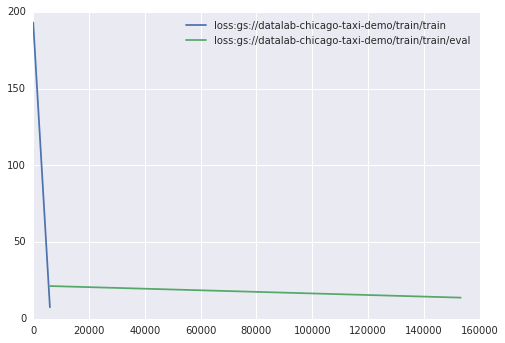

In [11]:
from google.datalab.ml import Summary

summary = Summary('gs://datalab-chicago-taxi-demo/train')
summary.plot('loss')

## Step 4: Evaluation using batch prediction

Below, we use the evaluation model and run batch prediction in cloud. For demo purpose, we will use the evaluation data again.

In [184]:
!rm -r -f ./taxi/batch_predict # Remove previous batch prediction results.

Currently, batch_prediction service does not work with BigQuery data. So we export eval data to csv file.

In [20]:
%%bq extract
table: chicago_taxi.eval
format: csv
path: gs://datalab-chicago-taxi-demo/eval.csv

Job bradley-playground/job_83_A9-weJOgbRzXAZytR29-YfmzR completed

Run batch prediction. Note that we use evaluation_model because it takes input data with target (truth) column.

In [3]:
%%ml batch_predict --cloud
model: gs://datalab-chicago-taxi-demo/train/evaluation_model
output: gs://datalab-chicago-taxi-demo/batch_prediction
format: csv
data:
  csv: gs://datalab-chicago-taxi-demo/eval.csv
cloud_config:
  region: us-east1

Job "prediction_170908_001217" submitted. Click here to view cloud log.

Once batch prediction is done, check results files. Batch prediction service outputs to JSON files.

In [ ]:
!gsutil list -l -h gs://datalab-chicago-taxi-demo/batch_prediction

We can load the results back to BigQuery.

In [ ]:
%%bq load
format: json
mode: overwrite  
table: chicago_taxi.eval_results
path: gs://datalab-chicago-taxi-demo/batch_prediction/prediction.results*
schema:
  - name: unique_key
    type: STRING
  - name: predicted
    type: FLOAT
  - name: target
    type: FLOAT

With data in BigQuery can do some query analysis. For example, RMSE.

In [24]:
%%ml evaluate regression
bigquery: chicago_taxi.eval_results

,metric,value
0,Root Mean Square Error,3.399688
1,Mean Absolute Error,1.510358
2,50 Percentile Absolute Error,0.889577
3,90 Percentile Absolute Error,2.916519
4,99 Percentile Absolute Error,11.848273


Select top results sorted by error.

In [7]:
%%bq query
SELECT
  predicted, 
  target,
  ABS(predicted-target) as error,
  s.* 
FROM `chicago_taxi.eval_results` as r 
JOIN `chicago_taxi.eval` as s 
ON r.unique_key = s.unique_key 
ORDER BY error DESC
LIMIT 10

predicted,target,error,unique_key,fare,weekday,day,hour,taxi_id,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,company
5.2171754837,197.770004272,192.552828789,357449c0af2cc90b5c49fb04087183ba7f90cea5,197.77,4,280,4,aaaabea26aa710b33659e37b2caf5152ccaf54c840b97caf523cadbf4000216c6d74b9a2d5d9860c9e25fe3e67eb08d1babca68fa5925d8aed84df6516e5b6a1,41.899602111,-87.633308037,41.899602111,-87.633308037,
7.86585140228,197.050003052,189.184151649,e2f0acebdc1d8ac7d998818e399e4b76505247e2,197.05,7,150,17,51c524f104bfb435ca69243dc44a846540a40538ee821fe2d3671b8976c1a0d0b2dc7302f3b952421a975cb41ce19d5edba5afbb2e677e5e9b3d82f44690591e,41.9867118,-87.663416405,42.009622881,-87.670166857,Taxi Affiliation Services
10.3806638718,199.25,188.869336128,321e7233f6c185cc19d0a1721426593c54435c79,199.25,6,43,21,4de82fc17cb23f745931085fbbb3b4f920550cda576979980750b7b4cd8e4b315d327ce76a9e599a4085e7f87b6bcb35b5159a72e90f161e56dea4af76180b5d,41.980264315,-87.913624596,41.980264315,-87.913624596,Dispatch Taxi Affiliation
8.66884994507,195.850006104,187.181156158,3b03f0108c84bc2b4c42ba874b0cfdccd72e575e,195.85,6,318,20,9322338f1c82b91b2a013447165b0718578f6e372315aded7947277cc4124f939ab6902f0e5339be0d3804dccdc3b383a4307a8338340f2df9a0e4e53e23478f,41.97907082,-87.903039661,41.97907082,-87.903039661,Dispatch Taxi Affiliation
6.33563327789,192.850006104,186.514372826,76266a055557deb60189004a10d5a43f48843c86,192.85,1,222,3,f56706cffdd1acc957c70c8ba9fd463a6af4b8a4c2093285acf87178836f87943be63db001743e8cd7e03c99e8024324a601c72b94c1cb753ceec91258001159,41.9867118,-87.663416405,41.96581197,-87.655878786,Blue Ribbon Taxi Association Inc.
13.6012525558,199.050003052,185.448750496,a759a0491eef2661c12027d5dc5283b64124a18c,199.05,2,342,14,f760c301740afe577d6c0e2f6de2cfecccf6ede158b8a3825331005da37a008716599169f4b467bc8b88e65318b5008499ad0ea4e05a7465c6bce4a1d5e70350,41.944226601,-87.655998182,42.009622881,-87.670166857,
5.46882343292,189.669998169,184.201174736,b0fb64578ac47490df8e94a223f0ec82613fa1f0,189.67,7,250,11,d58d43067fde7b7cabd7348969178e4f06049bb200348a381b6f2552dc0553ba22599766df9cf353eebae2ce7339e183d10b386046e5214fa3c9197d1a05b649,41.879066994,-87.657005027,41.879255084,-87.642648998,
5.24747657776,187.0,181.752523422,1bc27016f87f8de32dfead8b282c996e4ff0ce15,187.0,1,136,3,64f59b7a01c1221ff4d8b829f37f54b6f6151a394c87332c81d475385bdbc9db985293bc87d969ab58f44e50d4d5205e47a5e39df8c38f10b034168b76cfbc7f,41.892072635,-87.628874157,41.892507781,-87.626214906,Chicago Medallion Leasing INC
17.9648761749,196.050003052,178.085126877,1ac25e0730bbefa234752b6a2e6824296936cc82,196.05,4,134,21,f9aee16b2de2973e98d52db66fb4a63a8dfd859ac95f9a5fa3dc2c2af2b8b4102d6b886a9115509152a8fa875eeea7f4faf1814323ee61c49974209d31404a65,41.878865584,-87.625192142,41.96581197,-87.655878786,Taxi Affiliation Services
17.5570735931,194.649993896,177.092920303,18136afd91cf91f58bb664b5fba4c9f33ebe46b4,194.65,2,327,9,e78939aa02aa5c37e9d0dce81c2690d3de6675aa508e9a778e252dfb90c58aa467ca228a53e812b6f329e975b1428697f6d48dca3a9f9b5b4ee8f2384cf1849f,41.97907082,-87.903039661,41.97907082,-87.903039661,


There is also a feature slice visualization component designed for viewing evaluation results. It shows correlation between features and prediction results.

In [40]:
%%bq query --name error_by_hour
SELECT
  COUNT(*) as count,
  hour as feature,
  AVG(ABS(predicted - target)) as avg_error,
  STDDEV(ABS(predicted - target)) as stddev_error
FROM `chicago_taxi.eval_results` as r
JOIN `chicago_taxi.eval` as s 
ON r.unique_key = s.unique_key 
GROUP BY hour

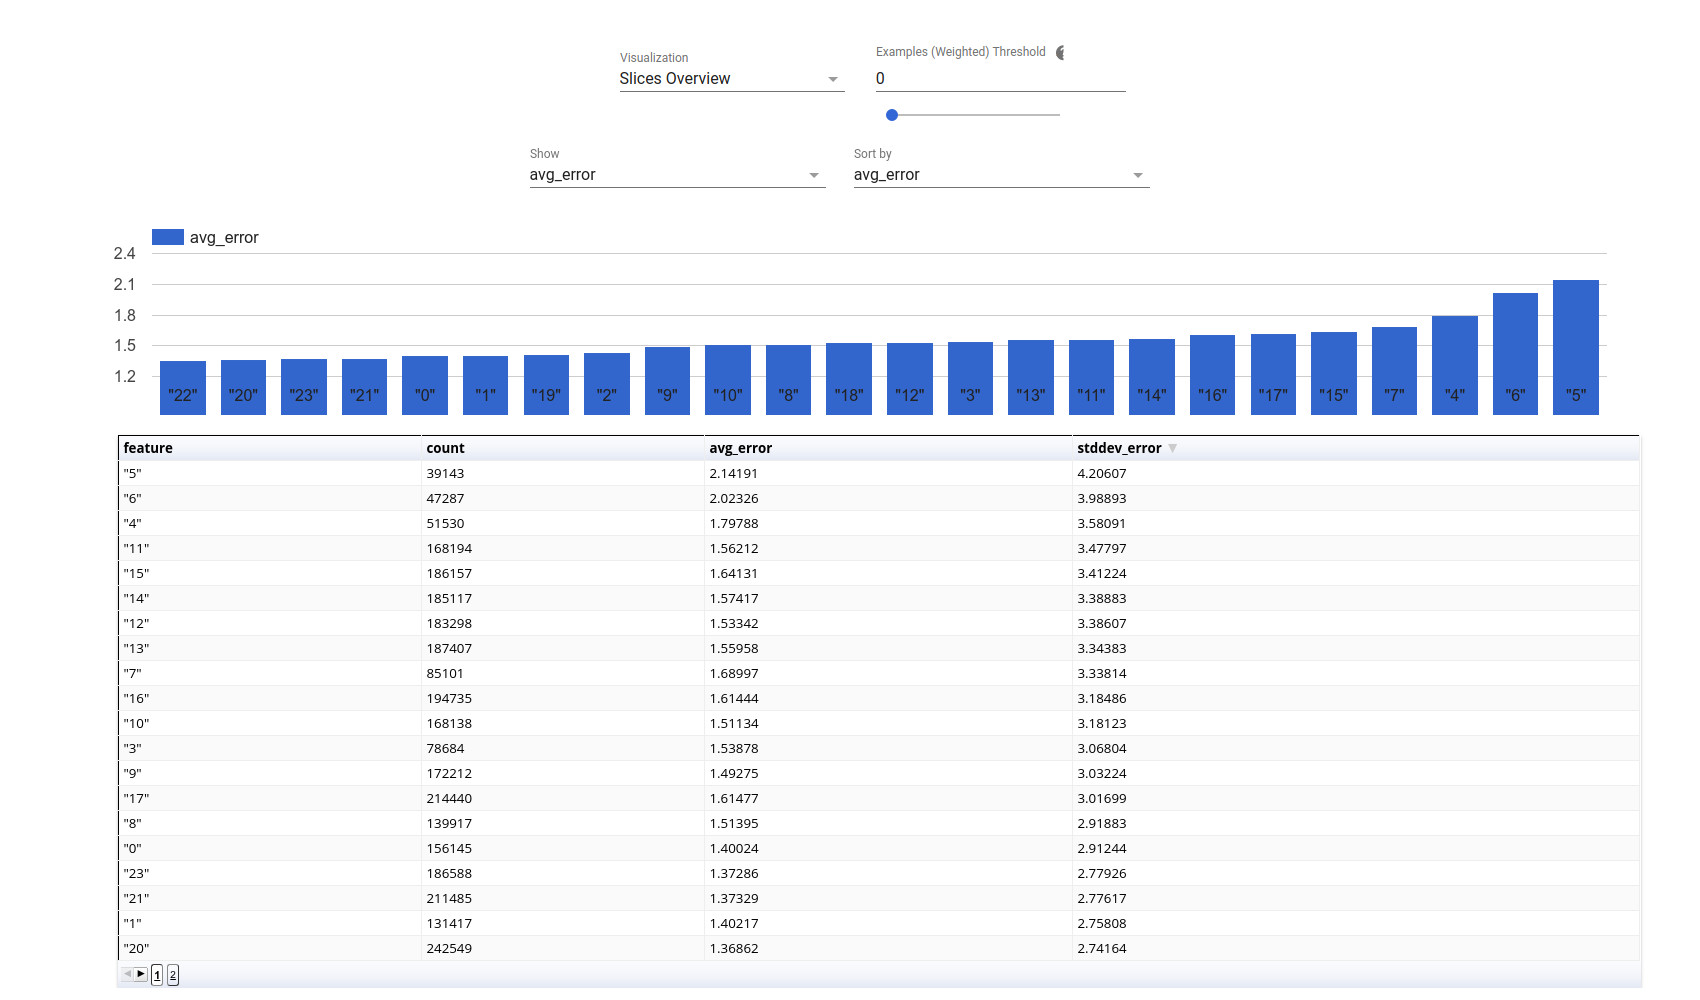

In [44]:
# Note: the interactive output is replaced with a static image so it displays well in github.
# Please execute this cell to see the interactive component.

from google.datalab.ml import FeatureSliceView

FeatureSliceView().plot(error_by_hour)

In [42]:
%%bq query --name error_by_weekday
SELECT
  COUNT(*) as count,
  weekday as feature,
  AVG(ABS(predicted - target)) as avg_error,
  STDDEV(ABS(predicted - target)) as stddev_error
FROM `chicago_taxi.eval_results` as r
JOIN `chicago_taxi.eval` as s 
ON r.unique_key = s.unique_key 
GROUP BY weekday

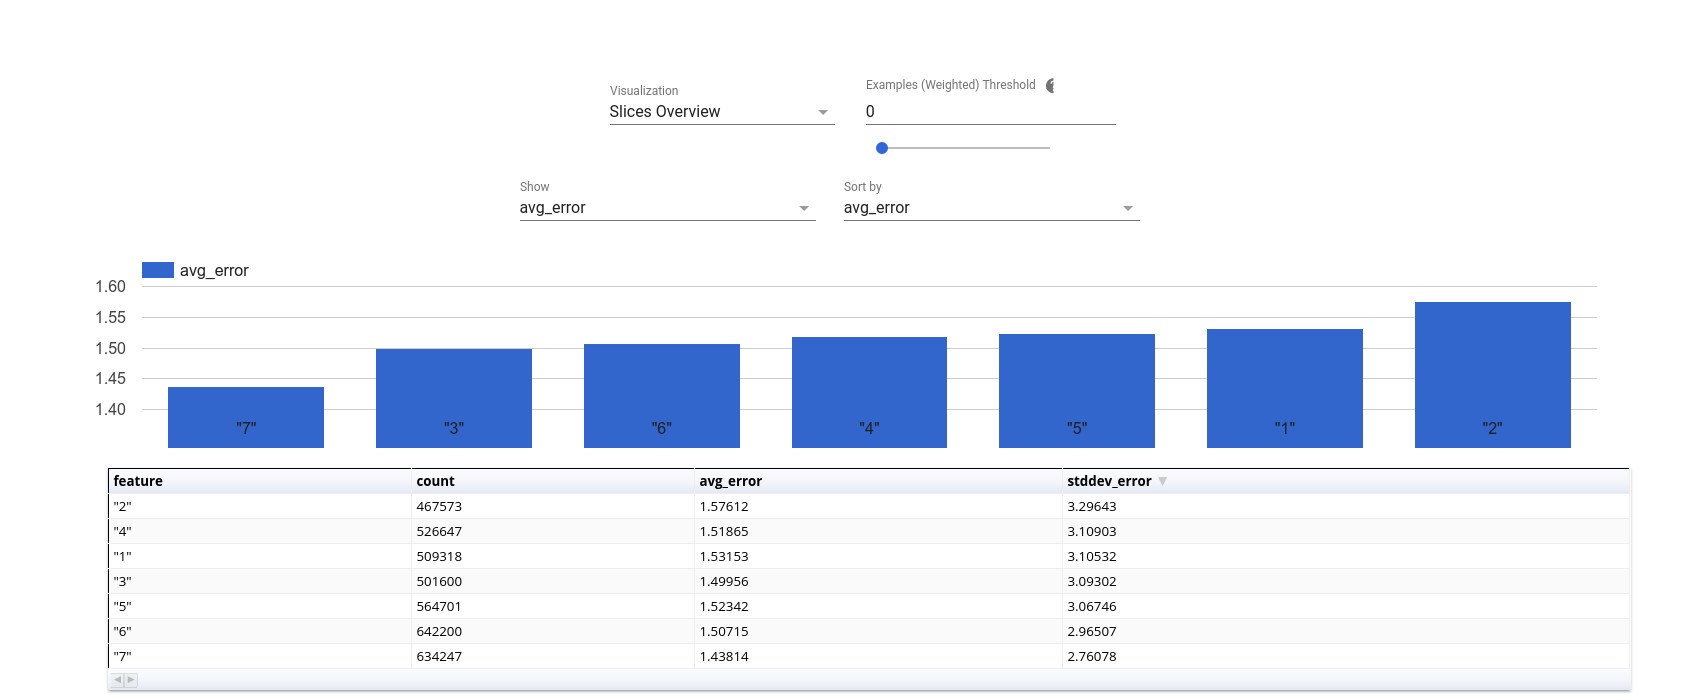

In [45]:
# Note: the interactive output is replaced with a static image so it displays well in github.
# Please execute this cell to see the interactive component.

from google.datalab.ml import FeatureSliceView

FeatureSliceView().plot(error_by_weekday)

What we can see from above charts is that model performs worst in hour 5 and 6 (why?), and best on Sundays (less traffic?).

# Model Deployment and Online Prediction

Model deployment works the same between locally trained models and cloud trained models. Please see previous notebook (Taxi Fare Model (small data)).

# Cleanup

In [ ]:
!gsutil -m rm -rf gs://datalab-chicago-taxi-demo